# **PERFORMANCE OF THE MODEL**

Here we do a summary of the performance of the model we built to predict predict the *GDP Growth of the next year* for each country in the world.

In [2]:
import sys
sys.path.append("..") # append the directory above where the databese is.
from utils import config
import pandas as pd
import numpy as np
import sqlite3
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### disable scientific notation in pandas
pd.set_option('display.float_format', '{:.2f}'.format) ### display up to 2 decimal pts

In [3]:
with sqlite3.connect(config.DATABASE_PATH) as connection:
    df = pd.read_sql("SELECT * FROM CountryIndicators", connection)

In [4]:
def clean_and_pivote(df):
    countries_gdp = df[df["IndicatorCode"] == config.GDP]["CountryCode"].to_list() #countries with gdp
    countries = df["CountryCode"].unique()
    countries_no_gdp = list(set(sorted(countries)) - set(sorted(countries_gdp))) # set difference =  countries with no gdp

    return df.pivot(index=["CountryCode","Year"], columns="IndicatorCode", values="Value").drop(countries_no_gdp)

In [5]:
df_cleaned = clean_and_pivote(df)
df_cleaned = df_cleaned[config.FEATURES]
df_cleaned.drop(index=range(1960, 1980), level="Year", inplace=True)

In [6]:
df_features = df_cleaned.copy()
df_target = df_cleaned.pop(config.GDP)
df_features.drop(index=2010, level="Year", inplace=True)
df_target.drop(index=1980, level="Year", inplace=True)

In [7]:
X = df_features
y = df_target.to_frame()
# genereate imputed dataframes by mean
X_imp = X.fillna(X.mean())
X_imp = np.array(X_imp)
y_imp = y.fillna(y.mean())
y_imp = np.array(y_imp)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)

In [45]:
model = xgb.XGBRegressor(max_depth=9, learning_rate=0.01, subsample=0.8, n_estimators=1000, base_score=y_train.mean())
model.fit(X_train, y_train)
pred = model.predict(X_test, output_margin=True)
print("Model absolute error =", mean_absolute_error(y_test, pred))
print("Model squared error =", mean_squared_error(y_test, pred))
print("R2 =", r2_score(y_test, pred))

Model absolute error = 2.600623362035159
Model squared error = 22.466704721930892
R2 = 0.3289076061025932


The proportion of the variance of *GDP Growth of the next year* that the model can explain is a 32.9\% (R2). This is not a lot that we can see in the following plots the predictions could been improved.

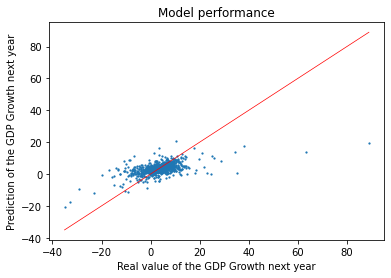

In [55]:
fig, ax = plt.subplots()
plot_range = [y_test.min(), y_test.max()]
ax.set_title("Model performance")
ax.set_ylabel("Prediction of the GDP Growth next year")
ax.set_xlabel("Real value of the GDP Growth next year")
ax.plot(plot_range, plot_range, c='red', linewidth=0.7)
ax.scatter(y_test, pred, s=1.475)
plt.show()

The closer the values are to the red line better are the predictions. 

We can see that our model does not fitted well the outliers, the points that are more distant from the mean. One possible reason is the imputation method we have used, due to the number of missing values we decide and the distribution of the *GDP Worth* we decide to impute whit the mean, that maybe makes the model less susceptible to predicting very high or very low values.

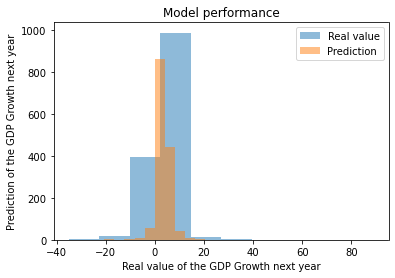

In [57]:
fig, ax = plt.subplots()
ax.set_title("Model performance")
ax.set_ylabel("Prediction of the GDP Growth next year")
ax.set_xlabel("Real value of the GDP Growth next year")
ax.hist(y_test, alpha=.5, label='Real value')
ax.hist(pred, alpha=.5, label='Prediction')
plt.legend()
plt.show()